In [1]:
import json
import numpy as np
from domain_objects import GameParams, NewAgent
from new_guessing_game import RandomFunctions, run_simulation, new_random_f, select_speaker, select_hearer, avg_series
from calculator import NumericCalculator, QuotientCalculator, Calculator


In [2]:
population_size=6
stimulus='quotient'
max_num=100
discriminative_threshold=0.95
discriminative_history_length=50
delta_inc=0.2
delta_dec=0.2
delta_inh=0.2
alpha=0.001
super_alpha=0.01
beta=0.2
steps=3100
runs=1
guessing_game_2=False
seed=0

params = GameParams(population_size=population_size,
               stimulus=stimulus,
               max_num=max_num,
               discriminative_threshold=discriminative_threshold,
               discriminative_history_length=50,
               delta_inc=delta_inc,
               delta_dec=delta_dec,
               delta_inh=delta_inh,
               alpha=alpha,
               super_alpha=super_alpha,
               beta=beta,
               steps=steps,
               runs=runs,
               guessing_game_2=guessing_game_2,
               seed=seed)


In [3]:
r = next(new_random_f(seed=params.seed))
agg_cs1 = []
agg_ds = []
calculator = {'numeric': NumericCalculator.load_from_file(),
                  'quotient': QuotientCalculator.load_from_file()}[params.stimulus]
population, states_sequences, states_edges_cnts, states_cnts = run_simulation(calculator, params, r.shuffle_list_random_function(), r.flip_a_coin_random_function(), r.pick_element_random_function())

windowed_communicative_success1 = np.array([avg_series(a.get_communicative_success1()) for a in population])*100
windowed_communicative_success2 = [avg_series(a.get_communicative_success2()) for a in population]
windowed_discriminative_success = np.array([avg_series(a.get_discriminative_success()) for a in population])*100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3100/3100 [00:06<00:00, 515.91it/s]


In [4]:
averaged_windowed_communicative_success1 = np.mean(windowed_communicative_success1, axis=0)
averaged_windowed_discriminative_success = np.mean(windowed_discriminative_success, axis=0)

# Analysis & Visualizations

## Single Agent Analysis

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from plot_utils import plot_category


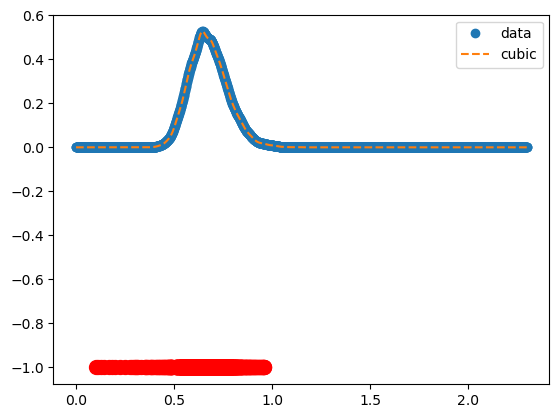

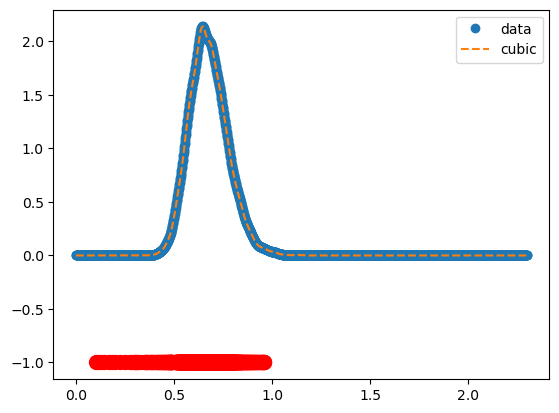

In [7]:
agent = population[0]
#agent_dict = NewAgent.to_dict(population[0])
#json.dumps(NewAgent.to_dict(population[0]))
meanings = agent.compute_word_meanings()
word, semantic_meanings = list(meanings.items())[1]
semantic_meanings = [round(num/denum,3) for num, denum in semantic_meanings]
c = agent.get_most_connected_category(word)
plot_category(c, semantic_meanings, calculator)
originated_from = word.originated_from_category
plot_category(originated_from, semantic_meanings, calculator)


In [8]:
agent = population[0]
recreated_agent_snapshots = NewAgent.recreate_from_history(agent_id=agent.agent_id, calculator=calculator, game_params=params, updates_history=agent.updates_history)

recreating agent 2 by updates: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3100/3100 [00:00<00:00, 4676.17it/s]


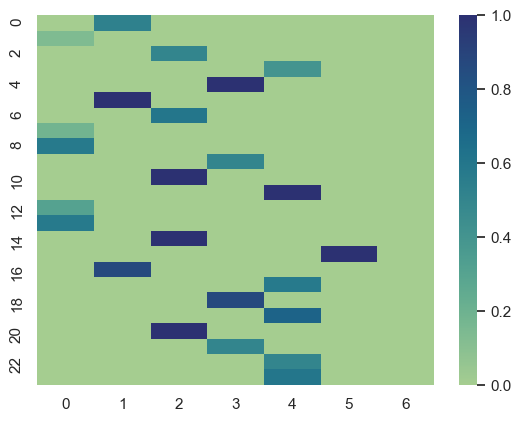

In [9]:
step, snapshot = recreated_agent_snapshots[30]
agent_dict = NewAgent.to_dict(snapshot)
lxc = np.array(agent_dict['lxc'])

sns.set()
ax = sns.heatmap(lxc, vmin=0, vmax=1, cmap="crest")
plt.show()

## Population Statistics

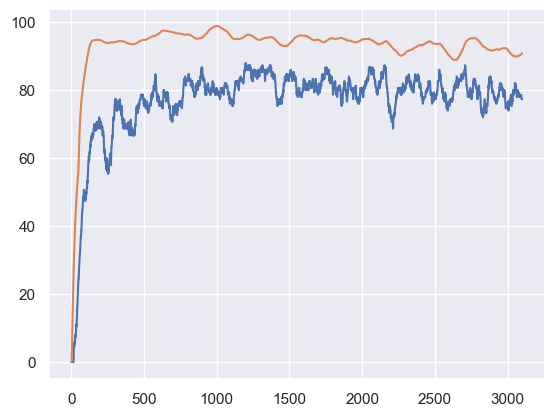

In [10]:
plt.plot(range(len(averaged_windowed_communicative_success1)), averaged_windowed_communicative_success1)
plt.plot(range(len(averaged_windowed_discriminative_success)), averaged_windowed_discriminative_success)

plt.show()


In [11]:
population_snapshots = [NewAgent.recreate_from_history(agent_id=a.agent_id, calculator=calculator, game_params=params, updates_history=a.updates_history)for a in population]

recreating agent 3 by updates: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3100/3100 [00:00<00:00, 6503.98it/s]


In [12]:
w2meanings = agent.compute_word_meanings()
is_word_monotone = {}
for w, meaning in w2meanings.items():
    is_word_monotone[w] = NewAgent.is_monotone_new(meaning, calculator)

In [13]:
is_word_monotone

{NewWord(word_id=2, originated_from_category=1[[1.4838355417387932]x[(13, 62)]]): False,
 NewWord(word_id=8, originated_from_category=0[[0.4990005]x[(55, 82)]]): False,
 NewWord(word_id=13, originated_from_category=2[[2.177744621027063]x[(49, 100)]]): False,
 NewWord(word_id=14, originated_from_category=4[[0.4997576008237804]x[(23, 71)]]): False,
 NewWord(word_id=7, originated_from_category=0[[0.7709268033860162]x[(73, 87)]]): False,
 NewWord(word_id=11, originated_from_category=3[[0.4995000349774744]x[(60, 83)]]): False,
 NewWord(word_id=12, originated_from_category=1[[0.6426512202309453]x[(31, 56)]]): False,
 NewWord(word_id=10, originated_from_category=3[[0.4986501057709456]x[(10, 83)]]): False,
 NewWord(word_id=18, originated_from_category=4[[3.6225870856763533]x[(1, 74)]]): False,
 NewWord(word_id=17, originated_from_category=0[[1.5621924516027095]x[(42, 43)]]): False,
 NewWord(word_id=0, originated_from_category=1[[0.4995006195393014]x[(26, 55)]]): False,
 NewWord(word_id=19, ori